In [1]:
import os
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib  as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
from PIL import Image
import math
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns; sns.set_style("white")

### Read data

In [2]:
BaseDir = 'Datasets'
sorted(os.listdir(BaseDir))

['.ipynb_checkpoints',
 'Features_5_percent_sample_Plate5.csv',
 'Features_images_MCR5_HCoV229_Plate5.csv',
 'Features_images_MRC5_HCoV229.csv',
 'qcRAW_images_MRC5_HCoV229_Plate1.csv',
 'qcRAW_images_MRC5_HCoV229_Plate2.csv',
 'qcRAW_images_MRC5_Plate3.csv',
 'qcRAW_images_MRC5_Plate4.csv']

In [3]:
ImageDataset = pd.read_csv(BaseDir + '/Features_images_MRC5_HCoV229.csv', sep=";", low_memory=False)
ImageDataset.tail(2)

,ImageID,Plate,Well,Site,LabelGroup,Dose,AreaShape_Area_primobj,AreaShape_BoundingBoxArea_primobj,AreaShape_BoundingBoxMaximum_X_primobj,AreaShape_BoundingBoxMaximum_Y_primobj,...,RadialDistribution_RadialCV_illumPHAandWGA_2of4_quatobj,RadialDistribution_RadialCV_illumPHAandWGA_3of4_quatobj,RadialDistribution_RadialCV_illumPHAandWGA_4of4_quatobj,RadialDistribution_RadialCV_illumPHAandWGA_Overflow_quatobj,RadialDistribution_RadialCV_illumSYTO_1of4_quatobj,RadialDistribution_RadialCV_illumSYTO_2of4_quatobj,RadialDistribution_RadialCV_illumSYTO_3of4_quatobj,RadialDistribution_RadialCV_illumSYTO_4of4_quatobj,RadialDistribution_RadialCV_illumSYTO_Overflow_quatobj,Intensity_MeanIntensity_illumMITO_quatobj
1023,Exp4-MRC5-L5-229E-sG118_cmp05 virus +,2,G11,8,cmp05 virus +,2,1344.930556,2005.666667,1274.097222,1170.805556,...,0.233317,0.012443,0.0,0.0,0.255600,0.310824,0.017736,0.0,0.0,0.054746
1024,Exp4-MRC5-L5-229E-sG119_cmp05 virus +,2,G11,9,cmp05 virus +,2,1344.744681,1971.968085,1126.074468,1110.170213,...,0.236934,0.015737,0.0,0.0,0.241466,0.316692,0.022129,0.0,0.0,0.050866


In [4]:
ImageDataset['Dose'] = ImageDataset['Dose'].astype(str).str[0]
ImageDataset['LabelGroupDose'] = ImageDataset['LabelGroup'] + ' ' + ImageDataset['Dose']
Groups = sorted(set(list(ImageDataset['LabelGroup'])))
ImageDataset.tail(2)

,ImageID,Plate,Well,Site,LabelGroup,Dose,AreaShape_Area_primobj,AreaShape_BoundingBoxArea_primobj,AreaShape_BoundingBoxMaximum_X_primobj,AreaShape_BoundingBoxMaximum_Y_primobj,...,RadialDistribution_RadialCV_illumPHAandWGA_3of4_quatobj,RadialDistribution_RadialCV_illumPHAandWGA_4of4_quatobj,RadialDistribution_RadialCV_illumPHAandWGA_Overflow_quatobj,RadialDistribution_RadialCV_illumSYTO_1of4_quatobj,RadialDistribution_RadialCV_illumSYTO_2of4_quatobj,RadialDistribution_RadialCV_illumSYTO_3of4_quatobj,RadialDistribution_RadialCV_illumSYTO_4of4_quatobj,RadialDistribution_RadialCV_illumSYTO_Overflow_quatobj,Intensity_MeanIntensity_illumMITO_quatobj,LabelGroupDose
1023,Exp4-MRC5-L5-229E-sG118_cmp05 virus +,2,G11,8,cmp05 virus +,2,1344.930556,2005.666667,1274.097222,1170.805556,...,0.012443,0.0,0.0,0.255600,0.310824,0.017736,0.0,0.0,0.054746,cmp05 virus + 2
1024,Exp4-MRC5-L5-229E-sG119_cmp05 virus +,2,G11,9,cmp05 virus +,2,1344.744681,1971.968085,1126.074468,1110.170213,...,0.015737,0.0,0.0,0.241466,0.316692,0.022129,0.0,0.0,0.050866,cmp05 virus + 2


### Output directory

In [5]:
OutputDir = input("Enter name for output folder: ") # e.g.: Exp4-MRC5-229ENotCytotoxic
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)

Enter name for output folder:  Results


In [6]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
   
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 1.75,
        height=ell_radius_y * 1.75,
        facecolor=facecolor,
        **kwargs)


    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [7]:
comps = ['cmp04 virus + ', 'cmp06 virus + ', 'cmp07 virus + ', 'DMSO virus + ', 'DMSO virus -']

compNames = {'cmp01 virus + ': 'TH3289', 'cmp02 virus + ': 'TH6744', 'cmp03 virus + ': 'TH5487', 'cmp04 virus + ': 'Remdesivir',
          'cmp06 virus + ': 'E-64d', 'cmp07 virus + ': 'Camostat', 'DMSO virus + ': 'DMSO virus + ', 'DMSO virus -': 'DMSO virus -'}

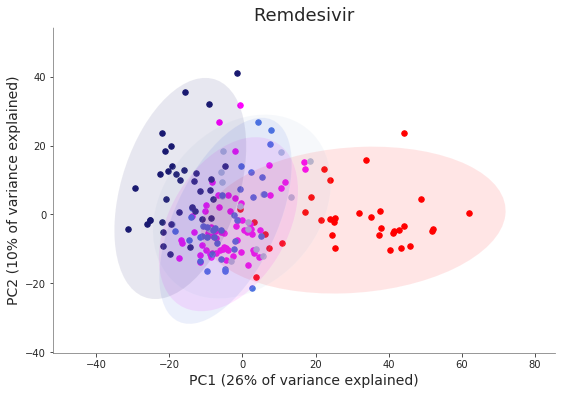

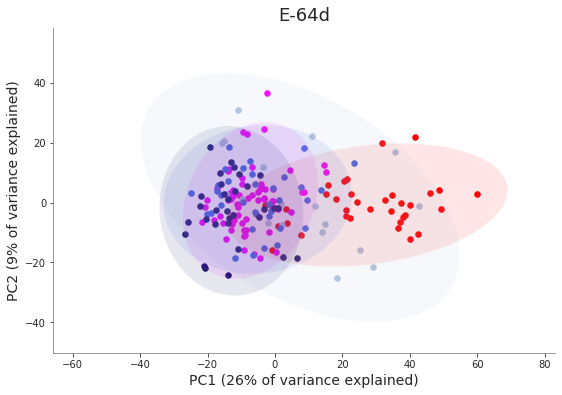

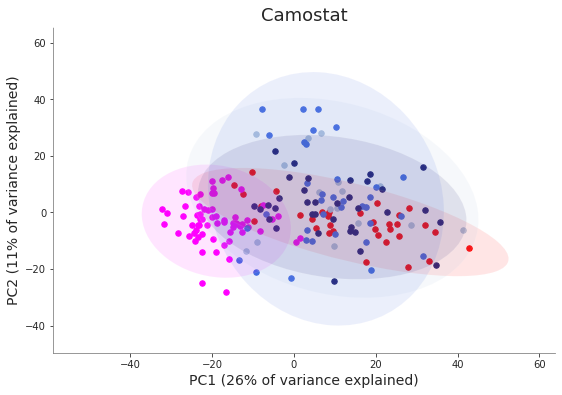

In [8]:
for c in comps[:3]:
    CompName = c
    CompNameFull = compNames.get(c)
    Remove = Groups.copy()
    Remove.remove(CompName)
    Remove.remove('DMSO virus + ')
    Remove.remove('DMSO virus -')

    DatasetPart = ImageDataset.copy()
    for ex in Remove: 
        DatasetPart = DatasetPart[DatasetPart.LabelGroup != ex]
    DatasetPart.reset_index(drop=True, inplace=True)
    #DatasetPart.reset_index(inplace=True)

    x = DatasetPart.iloc[:, 6:-2].values
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(x)

    ImagePrincipalDf = pd.DataFrame(data = principalComponents)
    ImagePrincipalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2',
                                    2: 'principal component 3'}, inplace=True)
    ImagePrincipalDf['Intensity_MeanIntensity_illumMITO_quatobj'] = DatasetPart['Intensity_MeanIntensity_illumMITO_quatobj']
    ImagePrincipalDf['ImageID'] = DatasetPart['ImageID']
    ImagePrincipalDf['LabelGroup'] = DatasetPart['LabelGroup']
    ImagePrincipalDf['Dose'] = DatasetPart['Dose']
    ImagePrincipalDf['LabelGroupDose'] = DatasetPart['LabelGroupDose']
   
    gr = (len(list(set(ImagePrincipalDf['LabelGroupDose']))))
    dictOfnumeric2 = { i : np.nanmean for i in ['principal component 1', 'principal component 2']}
    groupedbyCompDose = ImagePrincipalDf.groupby('LabelGroupDose').agg(dictOfnumeric2)
    
    if gr == 5:
        legend_elements = [Line2D([0], [0], color='w', marker='o', markerfacecolor='r', markersize=7, label='DMSO virus + '),
                           Line2D([0], [0], marker='o', color='w', label='DMSO virus \u2012 ',
                                  markerfacecolor='magenta', markersize=7),
                           Line2D([0], [0], marker='o', color='w', label='{} Low'.format(CompName),
                                  markerfacecolor='lightsteelblue', markersize=7),
                           Line2D([0], [0], marker='o', color='w', label='{} Mid'.format(CompName),
                                  markerfacecolor='royalblue', markersize=7),
                           Line2D([0], [0], marker='o', color='w', label='{} High'.format(CompName),
                                  markerfacecolor='midnightblue', markersize=7)]
        colors = ['r', 'magenta', 'lightsteelblue', 'royalblue', 'midnightblue']
    if gr == 4:
        legend_elements = [Line2D([0], [0], color='w', marker='o', markerfacecolor='r', markersize=7, label='DMSO virus + '),
                           Line2D([0], [0], marker='o', color='w', label='DMSO virus \u2012 ',
                                  markerfacecolor='magenta', markersize=7),
                           Line2D([0], [0], marker='o', color='w', label='{} Low'.format(CompName),
                                  markerfacecolor='lightsteelblue', markersize=7),
                           Line2D([0], [0], marker='o', color='w', label='{} Mid'.format(CompName),
                                  markerfacecolor='royalblue', markersize=7)]
        colors = ['r', 'magenta', 'lightsteelblue', 'royalblue']

    targets = sorted(list(set(ImagePrincipalDf['LabelGroupDose'])))
    fig = plt.figure(figsize = (9,6))
    ax = fig.add_subplot(111)
    ax.set_facecolor('w')
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['right'].set_color('w')
    ax.tick_params(
        axis='both',          
        which='both',    
        bottom=True,    
        left=True,   
        labelleft=True, 
        labelbottom=True)

    for target, color in zip(targets,colors):
            indicesToKeep = ImagePrincipalDf['LabelGroupDose'] == target
            ax.scatter(ImagePrincipalDf.loc[indicesToKeep, 'principal component 1']
                       , ImagePrincipalDf.loc[indicesToKeep, 'principal component 2']
                       , marker = 'o'
                       , c = color
                       , s = 30)
            confidence_ellipse(ImagePrincipalDf.loc[indicesToKeep, 'principal component 1']
                  , ImagePrincipalDf.loc[indicesToKeep, 'principal component 2'], ax, alpha = 0.1, facecolor=color)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xlim([xmin*1.4, xmax*1.1])
    ax.set_ylim([ymin*1.1, ymax*1.2])
    
    ax.set_xlabel('PC1 ({}% of variance explained)'.format (math.ceil(pca.explained_variance_ratio_[0]*100)),
                  fontsize=14)
    ax.set_ylabel('PC2 ({}% of variance explained)'.format (math.ceil(pca.explained_variance_ratio_[1]*100)),
                  fontsize=14)
    ax.set_title(CompNameFull, fontsize=18)

    fig.savefig('{}/{}_PC1_PC2.{}'.format(OutputDir, CompNameFull, 'pdf'),  dpi=300)

### PCA for reference compounds

In [9]:
Remove = Groups.copy()
Remove.remove('DMSO virus -')
Remove.remove('CTR1 virus -')
Remove.remove('CTR2 virus -')
Remove.remove('CTR3 virus -')

DatasetPart = ImageDataset.copy()
for ex in Remove: 
    DatasetPart = DatasetPart[DatasetPart.LabelGroup != ex]
DatasetPart.reset_index(drop=True, inplace=True)

In [10]:
x = DatasetPart.iloc[:, 6:-2].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

ImagePrincipalDf = pd.DataFrame(data = principalComponents)
ImagePrincipalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3'}, inplace=True)
ImagePrincipalDf['Intensity_MeanIntensity_illumMITO_quatobj'] = DatasetPart['Intensity_MeanIntensity_illumMITO_quatobj']
ImagePrincipalDf['ImageID'] = DatasetPart['ImageID']
ImagePrincipalDf['Plate_Comp'] = ImagePrincipalDf['ImageID'].str[10:12] + '_' + ImagePrincipalDf['ImageID'].str[24:28]
ImagePrincipalDf['LabelGroup'] = DatasetPart['LabelGroup']
ImagePrincipalDf.tail()

,principal component 1,principal component 2,principal component 3,Intensity_MeanIntensity_illumMITO_quatobj,ImageID,Plate_Comp,LabelGroup
166,-5.621902,-13.245926,-9.148454,0.002963,Exp4-MRC5-L5-229E-sG105_CTR3 virus -,L5_CTR3,CTR3 virus -
167,-10.010370,-10.797680,-10.344433,0.003014,Exp4-MRC5-L5-229E-sG106_CTR3 virus -,L5_CTR3,CTR3 virus -
168,-5.201535,-8.705568,-1.037914,0.002987,Exp4-MRC5-L5-229E-sG107_CTR3 virus -,L5_CTR3,CTR3 virus -
169,-5.237658,-19.664201,-9.800453,0.002969,Exp4-MRC5-L5-229E-sG108_CTR3 virus -,L5_CTR3,CTR3 virus -
170,-9.617336,-12.896511,-8.400648,0.002989,Exp4-MRC5-L5-229E-sG109_CTR3 virus -,L5_CTR3,CTR3 virus -


In [11]:
legend_elements = [
                       Line2D([0], [0], marker='o', color='w', label='Layout 1 Etoposide',
                              markerfacecolor='blue', markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='Layout 1 Fenbendazole',
                              markerfacecolor='darkgreen', markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='Layout 1 Metoclopramide',
                              markerfacecolor='darkorange', markersize=7),
                                              Line2D([0], [0], marker='o', color='w', label='Layout 1 DMSO',
                              markerfacecolor='magenta', markersize=7),
                           Line2D([0], [0], marker='^', color='w', label='Layout 2 Etoposide',
                              markerfacecolor='blue', markersize=8),
                       Line2D([0], [0], marker='^', color='w', label='Layout 2 Fenbendazole',
                              markerfacecolor='darkgreen', markersize=8),
                       Line2D([0], [0], marker='^', color='w', label='Layout 2 Metoclopramide',
                              markerfacecolor='darkorange', markersize=8),
                                              Line2D([0], [0], marker='^', color='w', label='Layout 2 DMSO',
                              markerfacecolor='magenta', markersize=8)]

colors = ['blue', 'darkgreen',  'darkorange','magenta', 'blue', 'darkgreen',  'darkorange','magenta']
marks = ['o','o','o','o','^','^','^','^' ]

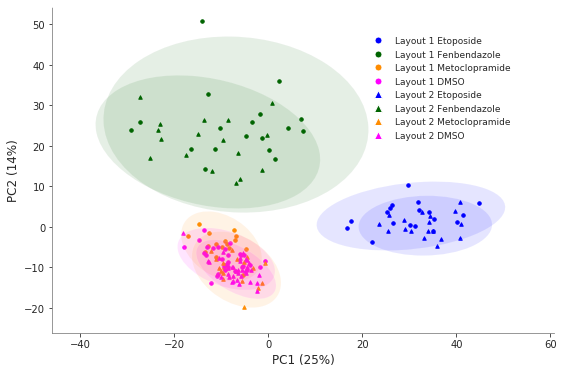

In [12]:
targets = sorted(list(set(ImagePrincipalDf['Plate_Comp'])))
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('grey')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['right'].set_color('w')
ax.tick_params(
        axis='both',         
        which='both',      
        bottom=True,     
        left=True,   
        labelleft=True, 
        labelbottom=True)

for target, color, mark in zip(targets,colors, marks):
        indicesToKeep = ImagePrincipalDf['Plate_Comp'] == target
        ax.scatter(ImagePrincipalDf.loc[indicesToKeep, 'principal component 1']
                   , ImagePrincipalDf.loc[indicesToKeep, 'principal component 2']
                   , marker = mark
                   , c = color
                   ,alpha = 1
                   , s = 12)
        confidence_ellipse(ImagePrincipalDf.loc[indicesToKeep, 'principal component 1']
              , ImagePrincipalDf.loc[indicesToKeep, 'principal component 2'], ax, alpha = 0.1, facecolor=color)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_xlim([xmin*1.1, xmax*1.1])
ax.set_ylim([ymin*1.1, ymax*1])

ax.set_xlabel('PC1 ({}%)'.format (math.ceil(pca.explained_variance_ratio_[0]*100)), fontsize=12)
ax.set_ylabel('PC2 ({}%)'.format (math.ceil(pca.explained_variance_ratio_[1]*100)), fontsize=12)


leg = fig.legend(handles=legend_elements, fontsize = 9, bbox_to_anchor=(0.80, 0.80), frameon=False)
fig.savefig('{}/{}_Image_PC1_PC2.{}'.format(OutputDir, 'CTR_and_DMSO', 'pdf'),  dpi=300)